In [166]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [167]:
df = pd.read_csv('data\cwdmappingdata_processed.csv')

C:\Users\chris\AppData\Local\Temp\ipykernel_46676\3099330829.py:1: DtypeWarning: Columns (11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,135,149,153,197,198,200) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data\cwdmappingdata_processed.csv')


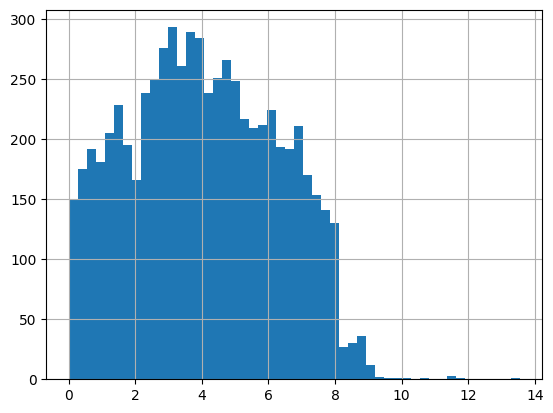

In [168]:
hist = df['age'].hist(bins=50)

count    2634.000000
mean        7.883068
std         3.017104
min         1.000000
25%         6.000000
50%         8.000000
75%        10.000000
max        20.000000
Name: risktotal, dtype: float64

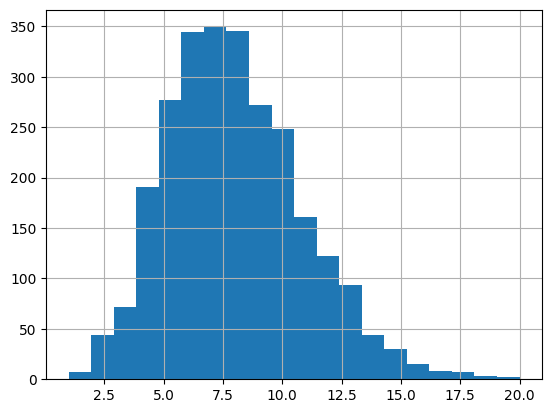

In [169]:
filtered=df['survey']=='under3'
hist = df['risktotal'][filtered].hist(bins=20)

df['risktotal'][filtered].describe()

Text(0.5, 1.0, 'Among children with at least 1 risk, how many risks of each category')

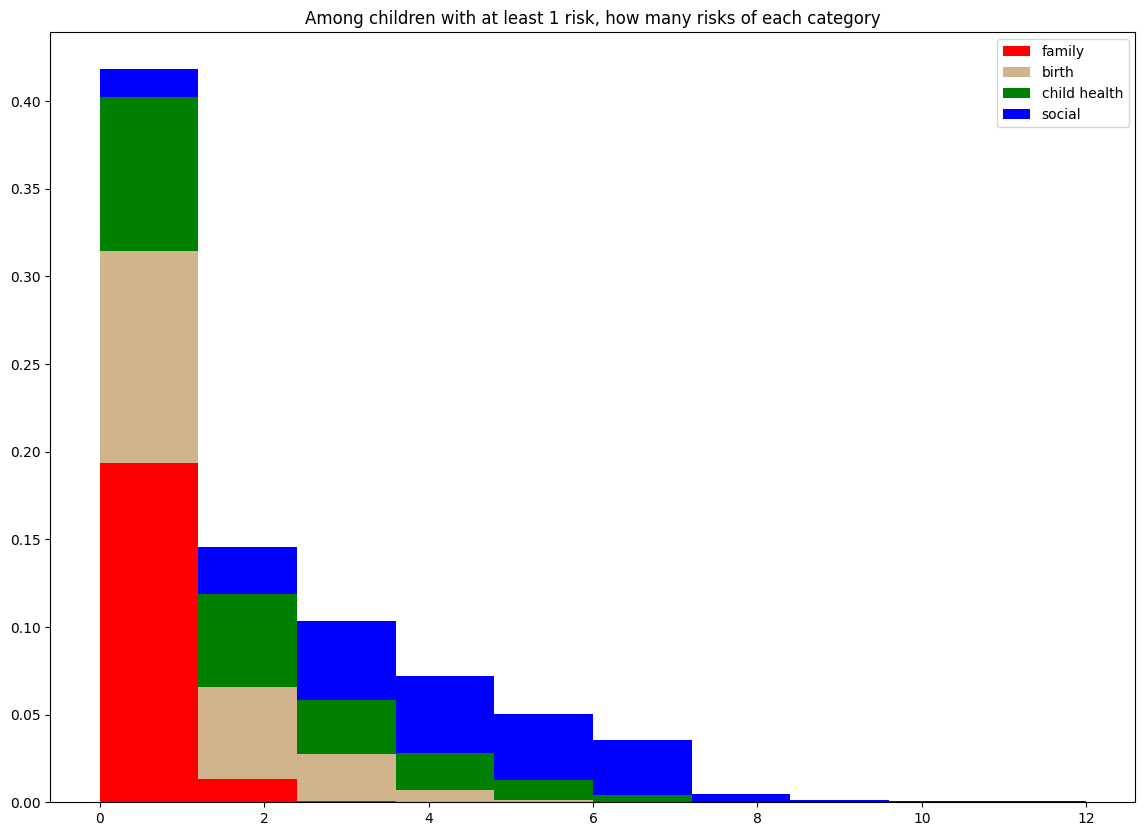

In [170]:
filtered=(df['survey']=='under3') & (df['risktotal']>0)
risks=[df['familyrisks'][filtered],df['birthrisks'][filtered],df['childhealthrisks'][filtered],df['socialrisks'][filtered]]
risknames=['family','birth','child health','social']

n_bins = 10
x = risks

fig, ax = plt.subplots(figsize=(14,10))

colors = ['red', 'tan','green','blue']
ax.hist(x, n_bins, density=1, histtype='bar', stacked=True, color=colors, label=risknames)
ax.legend(prop={'size': 10})
ax.set_title('Among children with at least 1 risk, how many risks of each category')

In [171]:
#logistic regression: Do the risk catgeories predict a developmental delay? 
    
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing

filtered=(df['survey']=='under3') &(df['sample']=='3cells')

data=df[['risk_developmentalmilestonedelay_yn','survey','sector','age','gender','risktotal','familyrisks','birthrisks','childhealthrisks','socialrisks']][filtered].dropna()

model = smf.logit(formula = 'risk_developmentalmilestonedelay_yn ~ age+gender+familyrisks+birthrisks+childhealthrisks+socialrisks+C(sector)', data=data)
#model = smf.logit(formula = 'risk_developmentalmilestonedelay_yn ~ age + gender + familyrisks + birthrisks + childhealthrisks + socialrisks + C(survey)', data=data,groups=data['village'])

result=model.fit()
print(result.summary())    

params = result.params
conf = result.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%','Odds Ratio']
confe=np.exp(conf)

#To convert from odds to a probability, divide the odds by one plus the odds. 
    #So to convert odds of 1/9 to a probability, divide 1/9 by 10/9 to obtain the probability of 0.10
confe['prob_5%']=(confe['5%']/(1+confe['5%']))    
confe['prob_odds']=(confe['Odds Ratio']/(1+confe['Odds Ratio']))
confe['prob_95%']=(confe['95%']/(1+confe['95%']))
confe

Optimization terminated successfully.
         Current function value: 0.295393
         Iterations 7
                                    Logit Regression Results                                   
Dep. Variable:     risk_developmentalmilestonedelay_yn   No. Observations:                  924
Model:                                           Logit   Df Residuals:                      915
Method:                                            MLE   Df Model:                            8
Date:                                 Wed, 09 Aug 2023   Pseudo R-squ.:                  0.1439
Time:                                         23:04:29   Log-Likelihood:                -272.94
converged:                                        True   LL-Null:                       -318.84
Covariance Type:                             nonrobust   LLR p-value:                 2.010e-16
                              coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

,5%,95%,Odds Ratio,prob_5%,prob_odds,prob_95%
Intercept,0.008191,0.058669,0.021921,0.008124,0.021451,0.055418
C(sector)[T.cyato],0.589253,1.715772,1.005497,0.370773,0.501370,0.631781
C(sector)[T.mageragere],0.654355,2.396133,1.252167,0.395535,0.555983,0.705547
age,0.666659,1.326421,0.940356,0.399997,0.484631,0.570155
gender,0.628109,1.535321,0.982013,0.385791,0.495462,0.605573
familyrisks,0.729551,1.613823,1.085065,0.421815,0.520399,0.617419
birthrisks,1.128746,1.842264,1.442030,0.530240,0.590505,0.648168
childhealthrisks,1.629290,2.349363,1.956474,0.619669,0.661759,0.701436
socialrisks,0.860583,1.155734,0.997299,0.462534,0.499324,0.536121


% of children in the 3cell sample with any functional disability
           disability3          
sample          3cells          
survey          under5    under9
district                        
nyamagabe     0.227907  0.102804
nyamasheke    0.041667  0.191406
nyarugenge    0.138264  0.201220


<Axes: xlabel='district'>

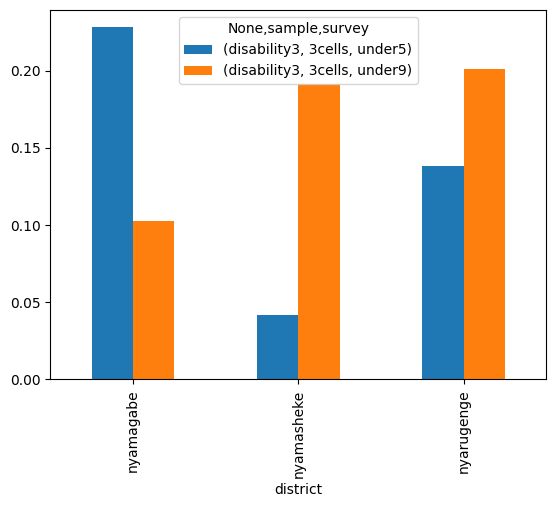

In [172]:
filtered=(df['survey']!='under3') & (df['sample']=='3cells') #& ((df['district']=='nyamagabe') | (df['district']=='nyamasheke') | (df['district']=='nyarugenge'))
df1=df[['sample','survey','sector','gender','ubudehe1234','district','disability3','seeing3', 'hearing3', 'walking3','motor3', 'understanding3', 'learning3', 'behavioural3', 'mental3']]
df1=df1[filtered]

pivot = pd.pivot_table(data=df1,index=['district'],columns=['sample','survey']
                      ,values=['disability3'], aggfunc=np.mean)

#table = pivot.reindex(pivot.sort_values(ascending=False).index)

print("% of children in the 3cell sample with any functional disability")
print(pivot)
pivot.plot(kind='bar')

ecd_cat
no info           889
primary school    538
ecd               216
Name: count, dtype: int64


<Axes: xlabel='survey,district'>

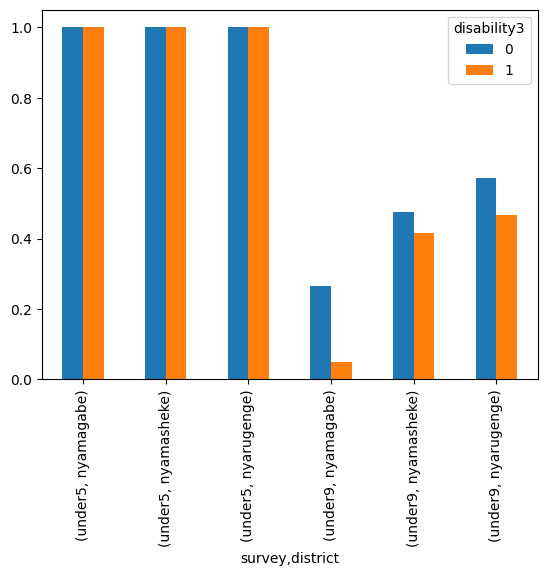

In [173]:
filtered=(df['survey']!='under3') #&(df['sample']=='3cells')
print(df['ecd_cat'][filtered].value_counts())


table = pd.pivot_table(data=df[filtered],index=['survey','district'],columns='disability3'
                      ,values='education01', aggfunc=np.mean)

table

table.plot(kind='bar')

gender         0         1
survey                    
under5  0.173913  0.080000
under9  0.181818  0.128205


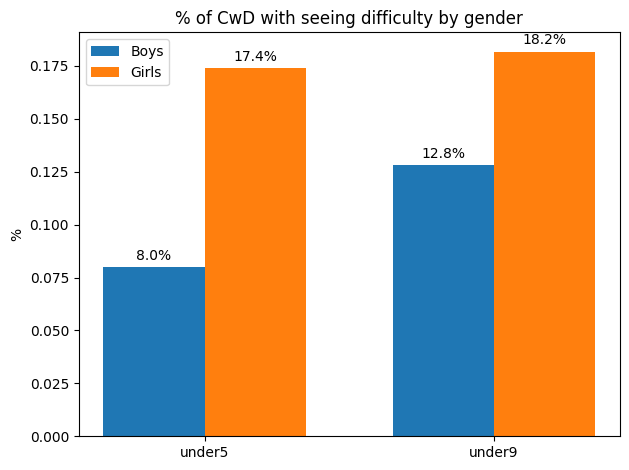

In [174]:
districts = ["nyabihu","musanze","gakenke"]
df1=df.query("district in @districts & sample=='22districts' & disability3==1")

values='seeing3' #hearing3,walking3,motor3, understanding3,learning3,behavioural3, mental4
index=['survey']
cols=['gender']
aggfunc=np.mean

table = pd.pivot_table(df1, values=values, index=index,
                    columns=cols, aggfunc=aggfunc)
print(table)

labels = ['under5', 'under9']
men_means = table[1].values
women_means = table[0].values

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Boys')
rects2 = ax.bar(x + width/2, women_means, width, label='Girls')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('%')
ax.set_title('% of CwD with seeing difficulty by gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}%'.format(round(height*100,1)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [175]:
#StatsModels Logit Formula

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing

filtered=(df['sample']=='3cells') & (df['age']>=3)& (df['age']<7)


df['age_std']=preprocessing.scale(df['age'])

data=df[['delayordis','survey','cell','village','education02','age','age_std','gender','disability4']][filtered].dropna()

#model = smf.logit(formula = 'education01 ~ age + gender + disability + C(sector)', data=data)
model = smf.logit(formula = 'education02 ~ age_std + gender + disability4 + C(survey) + C(cell)', data=data)


result=model.fit()
print(result.summary())

params = result.params
conf = result.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%','Odds Ratio']
confe=np.exp(conf)

#To convert from odds to a probability, divide the odds by one plus the odds. 
    #So to convert odds of 1/9 to a probability, divide 1/9 by 10/9 to obtain the probability of 0.10
confe['prob_5%']=(confe['5%']/(1+confe['5%']))    
confe['prob_odds']=(confe['Odds Ratio']/(1+confe['Odds Ratio']))
confe['prob_95%']=(confe['95%']/(1+confe['95%']))
confe

         Current function value: 0.534237
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:            education02   No. Observations:                 1186
Model:                          Logit   Df Residuals:                     1179
Method:                           MLE   Df Model:                            6
Date:                Wed, 09 Aug 2023   Pseudo R-squ.:                  0.2095
Time:                        23:04:32   Log-Likelihood:                -633.60
converged:                      False   LL-Null:                       -801.55
Covariance Type:            nonrobust   LLR p-value:                 1.648e-69
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  -23.0516   8751.370     -0.003      0.998   -1.72e+04    1.71e+04
C(survey)[T.under9]    

c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


,5%,95%,Odds Ratio,prob_5%,prob_odds,prob_95%
Intercept,0.000000,inf,9.745465e-11,0.000000,9.745465e-11,NaN
C(survey)[T.under9],0.000000,inf,2.720659e+10,0.000000,1.000000e+00,NaN
C(cell)[T.kankuba],0.519096,0.972491,7.105044e-01,0.341714,4.153771e-01,0.493027
C(cell)[T.kizimyamuriro],2.433289,4.771865,3.407540e+00,0.708734,7.731161e-01,0.826746
age_std,0.232415,0.479119,3.336978e-01,0.188585,2.502049e-01,0.323922
gender,0.758566,1.293150,9.904239e-01,0.431355,4.975945e-01,0.563919
disability4,1.751111,4.894233,2.927516e+00,0.636511,7.453861e-01,0.830343


In [176]:
# #Decision Tree

# feature_cols = feature_list
# X = dfrisk # Features
# y = labels # Target variable

# # Split dataset into training set and test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=1) # 80% training and 20% test

# train_features=X_train
# train_labels=y_train
# test_features=X_test
# test_labels=y_test


# print('Training Features Shape:', train_features.shape)
# print('Training Labels Shape:', train_labels.shape)
# print('Testing Features Shape:', test_features.shape)
# print('Testing Labels Shape:', test_labels.shape)

# # Create Decision Tree classifer object
# clf = DecisionTreeClassifier()

# # Train Decision Tree Classifer
# clf = clf.fit(X_train,y_train)

# #Predict the response for test dataset
# y_pred = clf.predict(X_test)

# # Create Decision Tree classifer object
# clf = DecisionTreeClassifier(criterion="gini", max_depth=4)

# # Train Decision Tree Classifer
# clf = clf.fit(X_train,y_train)

# #Predict the response for test dataset
# y_pred = clf.predict(X_test)

# # Model Accuracy, how often is the classifier correct?
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# #print("precision score : "+str(precision_score(y_test,y_pred))) # tp/tp+fp
# #print("accuracy score : "+str(accuracy_score(y_test,y_pred))) # total correct 
# #print("recall score : "+str(recall_score(y_test,y_pred)))   # tp/tp+fn
# #print("f1 score : "+str(f1_score(y_test,y_pred))) 

# confusion_matrix = confusion_matrix(y_true=y_test,y_pred=y_pred)

# sns.heatmap(confusion_matrix,annot=True,annot_kws={"size":16})
# plt.show()

# confusion_matrix

# print(clf.classes_)

# feature_names=feature_list
# class_names=['No','Yes']

# #fig, ax = plt.subplots(figsize=(100, 100))  # whatever size you want
# #tree.plot_tree(clf, filled=True,label='all',feature_names=feature_names,class_names=class_names)
# #plt.show()

# import graphviz 
# delay = tree.export_graphviz(clf, out_file=None, 
#                                 feature_names=feature_list,  
#                                 class_names=['Yes','No'],  
#                                 filled=True, rounded=True,  
#                                 special_characters=True)  
# graph = graphviz.Source(delay)
# graph

# max_depth = []
# acc_gini = []
# acc_entropy = []
# for i in range(1,30):
#     dtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
#     dtree.fit(X_train, y_train)
#     pred = dtree.predict(X_test)
#     acc_gini.append(accuracy_score(y_test, pred))
    
#     dtree = DecisionTreeClassifier(criterion='entropy', max_depth=i)
#     dtree.fit(X_train, y_train)
#     pred = dtree.predict(X_test)
#     acc_entropy.append(accuracy_score(y_test, pred))
#     max_depth.append(i)
    
# d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
#  'acc_entropy':pd.Series(acc_entropy),
#  'max_depth':pd.Series(max_depth)})

# # visualizing changes in parameters
# plt.plot('max_depth','acc_gini', data=d, label='gini')
# plt.plot('max_depth','acc_entropy', data=d, label='entropy')
# plt.xlabel('max_depth')
# plt.ylabel('accuracy')
# plt.legend()

In [177]:
#Selected Variables

dfrisk=df[['sample','survey','district','gender','risk_developmentalmilestonedelay_yn','district',#'age',
 #'risk_mumage_1stborn',
 'risk_mumage_this',
 #'risk_dadage_1stborn',
 'risk_dadage_this',
 'risk_parentsrelated_yn',
 'risk_orphan_yn',
 'child_position',
 #'risk_pregcomplication',
 'risk_medication_yn',
 'risk_childbornwhere',
 'risk_birthattendant_who',
 'risk_birth_atwhatstage',
 'risk_birthweight',
 #'risk_birthcomplication_which',
 'risk_wayofeatingdrinking',
 'risk_baby_fedhow',
 #'risk_solidmeals',
 'risk_vaccine_yn',
 #'risk_nutritionalstatus',
 #'risk_health_condition',
 #'impairment_cat',
 #'risk_impairment_cat',
 'risk_mother_healthissue',
 'risk_father_healthissue',
 #'family_impairment_cats',
 'risk_family_impairment',
 'risk_mother_schoollevel',
 'risk_father_schoollevel',
 'risk_ubudehe',
 'risk_mother_daysworked',
 #'risk_father_daysworked',
 'risk_child_where',
 'risk_playwithchild_ord',
 'risk_talktochild_ord',
 #'risk_readtochild_ord',
 #'risk_singtochild_ord',
 #'risk_teachchild_ord',
 'risk_fathertakescare_yn']]

# for x in list(dfrisk.columns.values):
#     print(x,df[x][df['survey']=='under3'].isna().sum())
    
# list(dfrisk.columns.values)

In [178]:
#Random Forest Classifier (code: https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/random_forest_explained/Random%20Forest%20Explained.ipynb)

In [179]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

#Metrics

from sklearn import metrics
from sklearn.metrics import roc_auc_score,accuracy_score,recall_score,precision_score,confusion_matrix,f1_score

#Continuous variable:

def RFRegressor(data,y,train_filter,test_filter):

    df_train=data[:][train_filter]
    df_test=data[:][test_filter]

    print(df_train.shape)
    print(df_test.shape)

    # Split the data into training and testing sets
        #train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.5, random_state = 42)
        #X_train, X_test, y_train, y_test
    train_features=np.array(df_train.drop(y,axis=1))
    test_features=np.array(df_test.drop(y,axis=1))
    train_labels=np.array(df_train[y])
    test_labels=np.array(df_test[y])

    feature_list = list(df_train.drop(y,axis=1).columns)
    
    #We can look at the shape of all the data to make sure we did everything correctly. 
    #We expect the training features number of columns to match the testing feature number of columns 
        #and the number of rows to match for the respective training and testing features and the labels
    print('Training Features Shape:', train_features.shape)
    print('Training Labels Shape:', train_labels.shape)
    print('Testing Features Shape:', test_features.shape)
    print('Testing Labels Shape:', test_labels.shape)

    # Import the model we are using

    # Instantiate model 
    rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

    # Train the model on training data
    rf.fit(train_features, train_labels)

    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)

    # Calculate the absolute errors
    errors = abs(predictions - test_labels)

    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
    
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / test_labels)

    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')

    feature_imp = pd.Series(rf.feature_importances_,index=feature_list).sort_values(ascending=False)
    print(feature_imp)

    print(stats.describe(errors)) #test_labels

    # q-q plot
    qqplot(errors, line='s')
    pyplot.show()

#Binary Variable:

def RFClassifier(data,y,train_filter,test_filter):

    df_train=data[:][train_filter]
    df_test=data[:][test_filter]

    print(df_train.shape)
    print(df_test.shape)

    # Split the data into training and testing sets
        #train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.5, random_state = 42)
        #X_train, X_test, y_train, y_test
    train_features=np.array(df_train.drop(y,axis=1))
    test_features=np.array(df_test.drop(y,axis=1))
    train_labels=np.array(df_train[y])
    test_labels=np.array(df_test[y])

    feature_list = list(df_train.drop(y,axis=1).columns)
    
    #We can look at the shape of all the data to make sure we did everything correctly. 
    #We expect the training features number of columns to match the testing feature number of columns 
        #and the number of rows to match for the respective training and testing features and the labels
    print('Training Features Shape:', train_features.shape)
    print('Training Labels Shape:', train_labels.shape)
    print('Testing Features Shape:', test_features.shape)
    print('Testing Labels Shape:', test_labels.shape)    
    
    # Create the model with 100 trees
    model = RandomForestClassifier(n_estimators=100,
                                   oob_score = True,
                                   bootstrap = True,
                                   min_samples_split=50,
                                   max_features = 'sqrt') 
    # Fit on training data
    model.fit(train_features, train_labels)

    # Actual class predictions
    rf_predictions = model.predict(test_features)
    
    # Probabilities for each class
    rf_probs = model.predict_proba(test_features)[:, 1]

    # Calculate roc auc
    roc_value = roc_auc_score(test_labels, rf_probs)
    print(roc_value)
    
    fpr, tpr, thresholds = metrics.roc_curve(test_labels, rf_probs)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

(1326, 84)
(1308, 84)
Training Features Shape: (1326, 83)
Training Labels Shape: (1326,)
Testing Features Shape: (1308, 83)
Testing Labels Shape: (1308,)


0.5853331654100141


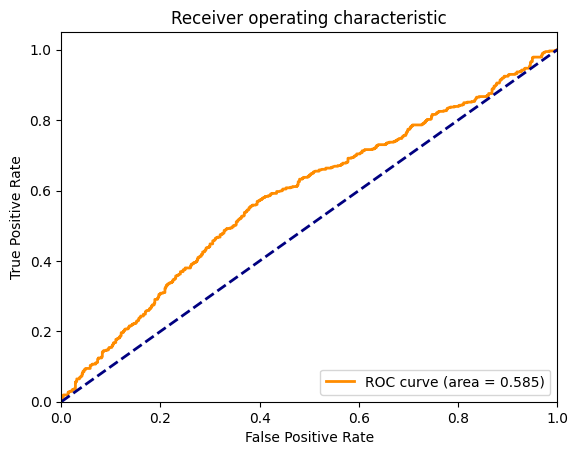

In [180]:
#Set Random Forest Variables
df_data=dfrisk.fillna(0) #no district
df_data=pd.get_dummies(df_data).dropna()
data=df_data
y='risk_developmentalmilestonedelay_yn'

# Use representative sample (3cell) data as the training set
    #Use CwD selected (22district) data to test - are there shared variables?
train_filter=(data['sample_3cells']==1) & (data['survey_under3']==1)
test_filter=(data['sample_22districts']==1) & (data['survey_under3']==1)

RFClassifier(data,y,train_filter,test_filter)

In [181]:
def prepare_data(df,varlist,ycol):
    # cols=[]
    # cols.extend([y])
    # cols.extend(xcols)
    df1=pd.get_dummies(df, columns=["sample","survey","district","insurance_yn"],
               prefix=["sample","survey","district","insurance"])
    
    data=df1[df1[ycol].notnull()]

    less=0.90
    cutoff=(1-less)*len(data.index)
    print("n/a cutoff: ",cutoff)
    
    reg_cols=[]
    for col in list(data.columns.values):
        na=data[col].isna().sum()
        if na<cutoff:
            if data[col].dtypes in ('float64','int64','uint8'):
                print(col,data[col].dtypes,na)
                reg_cols.append(col)
        else:
            print("rejected: ",col,data[col].dtypes,na)
    
    remove_cols=[ycol,'risk_developmentalmilestonedelay_yn','Unnamed: 0','code','risktotal']
    regex1 = re.compile('morethan*')
    regex2 = re.compile('risks$')
    reg_cols = [c for c in reg_cols if c not in set(remove_cols) and not regex1.search(c) and not regex2.search(c)]

    cols=reg_cols.copy()            
    cols.extend([ycol])

    data=data[cols].dropna()

    y = data[ycol]
    X = data[reg_cols]
    print("y = ",ycol)
    
    
    return y,X,reg_cols,data


In [182]:
def random_forest_classifier(X,y,var):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

    regr = RandomForestClassifier(bootstrap=True,
                                  class_weight = dict({0:1, 1:5}),#"balanced", 
                                  #it is important to minimise false negatives (bottom left in conf_mat)
                                  #Because its better to predict dis if not that to miss a child who is dis 
                                  n_estimators=200,#var
                                  max_depth=5,
                                  min_samples_leaf=20,
                                  min_samples_split=50,
                                  n_jobs=-1,
                                  random_state=42)
    regr.fit(X_train, y_train)
    score=regr.score(X_train,y_train)
    print("Score: ",score)

    feature_imp = pd.Series(regr.feature_importances_,index=reg_cols).sort_values(ascending=False)

    sns.barplot(x=feature_imp[:20], y=feature_imp.index[:20])
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.show()

#     print(feature_imp[:20])

    y_pred = regr.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_pred)
    print("\n","~~~Confusion Matrix~~~")
    cm_display = ConfusionMatrixDisplay(conf_mat).plot()
    misclassified= conf_mat[1][0]/sum(conf_mat[1])
    print("Misclassified CwD (%): ", misclassified*100)
    print("Score: ", score*100)
    return score

# model = sm.OLS(y, X)
# results = model.fit()
# print(results.summary(yname='delayordis'))

n/a cutoff:  218.69999999999996
Unnamed: 0 int64 0
code int64 0
rejected:  dob object 424
gender int64 0
rejected:  reasonwhy_noinsurance object 2049
rejected:  sibling1age object 596
rejected:  sibling2age object 1029
rejected:  sibling3age object 1386
rejected:  sibling4age object 1717
rejected:  sibling5age object 1970
rejected:  othersiblingages object 2092
rejected:  attendantenatal_yn object 1317
rejected:  attendantenatal_ntimes float64 1359
rejected:  pregcomplication_which object 1485
rejected:  medicationfromwhere object 358
rejected:  birthcomplication_which object 1519
rejected:  baby_solidseaten object 428
rejected:  solidmeals object 298
rejected:  nutritionalstatus object 864
rejected:  Child's_weights_compared_to_his/her_age_(Latest_measures) object 2126
rejected:  MUAC_(Current_measures) object 2131
rejected:  growth_testedregularly_yn object 1527
rejected:  Child_has_been_removed_amongest_those_with_anti-malnutrition_program_(For_last_6_months) object 1832
rejected:  

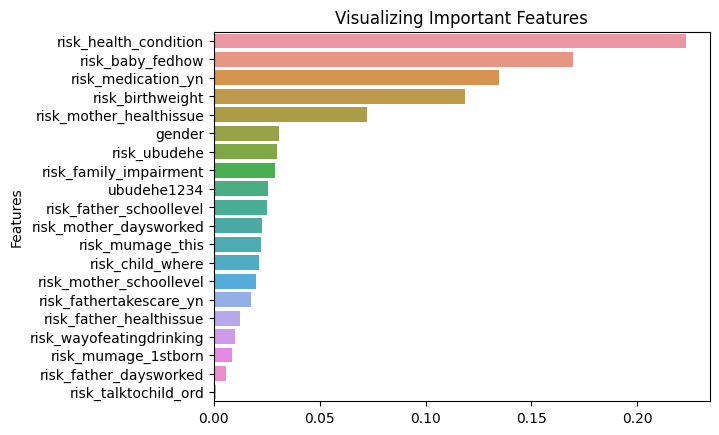


 ~~~Confusion Matrix~~~
Misclassified CwD (%):  2.083333333333333
Score:  40.30054644808743


0.4030054644808743

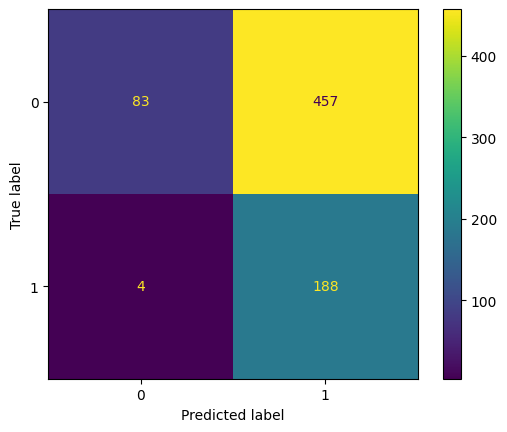

In [183]:
pd.set_option('display.max_rows', 500)

u3filter=(df['survey']=="under3") #& (df['sample']=='3cells')
u3=df[u3filter]
df=u3
varlist=list(df.columns.values)
ycol='delayordis'

y,X,reg_cols,data=prepare_data(df,varlist,ycol)

random_forest_classifier(X,y,1)

In [184]:
# #hyper-parameter tuning

# def hyperparameter_tuning(X,y,minh,maxh):
#     a=[]
#     b=[]
#     for i in range(minh,maxh):
#         s=random_forest_classifier(X,y,i)
#         a.append(i)
#         b.append(s)
#         print(i,s)
#     return a,b

# minh=2
# maxh=200

# a, b = hyperparameter_tuning(X,y,minh,maxh)

In [185]:
# import statsmodels.api as sm
# from numpy.random import randn
# from numpy.random import seed
# from scipy.stats import pearsonr


# def logistic(df1,X,Xcols,ys):
    
#     cols=X+Xcols+Xcats+ys
#     allcols=df1[list(cols)].dropna(inplace=False)
#     Xl=pd.get_dummies(allcols)

#     for y in ys:
#         try:
#             model = sm.Logit(allcols[y], sm.add_constant(Xl))
#             result = model.fit()
#             print(y,result.prsquared)
#             print(result.pred_table(),result.summary())
#             mfx = result.get_margeff(method='eyex')
#             print(mfx.summary()) #‘dydx’ - change in endog for a change in exog //‘eyex’ - proportional change in endog for a proportional change in exog.
#         except Exception as err:
#             print(y, "Error: ",err)
            
# X=['disability4','gender']
# Xcats=['district']
# Xcols=['sample', 'survey','ecd_cat']
# ys=['centre-based ecd', 'home-based ecd', 'no info', 'none','primary school']
   
# filtered=(df['survey']!='under3') & (df['sample']=='3cells') & (df['ecdtype_cat']!='no info')
# logistic(df1=df[filtered],X=X,Xcols=Xcols,ys=ys)

# #attending 'ecd_01'

In [186]:
# #Factor analysis - https://www.datacamp.com/community/tutorials/introduction-factor-analysis?utm_source=adwords_ppc&utm_campaignid=9942305733&utm_adgroupid=100189364546&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034352&utm_targetid=aud-517318241987:dsa-929501846124&utm_loc_interest_ms=&utm_loc_physical_ms=1007247&gclid=CjwKCAjwgdX4BRB_EiwAg8O8HeXWb3qq5WhJCnC4pOTRDPAsikL9LGILpgWk9RV2oHJQIg-9FJA_KhoCDToQAvD_BwE
# from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
# from factor_analyzer.factor_analyzer import calculate_kmo
# from factor_analyzer import FactorAnalyzer

# def factor_analysis(df,n):

#     df.dropna(inplace=True)

#     #Adequacy test
#         #Bartlett’s test
#             #If the test found statistically insignificant, you should not employ a factor analysis.

#     chi_square_value,p_value=calculate_bartlett_sphericity(df)

# #     print("Bartlett ’s test:",chi_square_value, p_value, "If the p-value is 0, the test was statistically significant, indicating that the observed correlation matrix is not an identity matrix")

#     kmo_all,kmo_model=calculate_kmo(df)

# #     print("Kaiser-Meyer-Olkin Test:",kmo_model,"The higher the better - 0.1829 is not very good")

#     #Choose number of factors
#         #Create factor analysis object and perform factor analysis

#     fa = FactorAnalyzer(rotation="varimax",n_factors=n)
#     fa.fit(df)
#     fa.loadings_

#     #Check Eigenvalues
#     ev, v = fa.get_eigenvalues()
# #     print(ev)

#     plt.scatter(range(1,df.shape[1]+1),ev)
#     plt.plot(range(1,df.shape[1]+1),ev)
#     plt.title('Scree Plot')
#     plt.xlabel('Factors')
#     plt.ylabel('Eigenvalue')
#     plt.grid()
#     plt.show()

#     print("% variance explained by first "+str(n)+" factors: ",fa.get_factor_variance()[2][n-1])
    
#         # Get variance of each factors
#             #fa.get_factor_variance()
#             #Total x% cumulative Variance explained by the 6 factors.
# nvars=3
# factor_analysis(fadf[X],n=nvars)

# #What are the factors?????

In [187]:
#Demographic Breakdowns

#22 districts - Demographics of people with disabilities

# Most likely developmental delay risks
    #exploratory factor analysis: most important risks in determining a developmental delay
# Cross-tabulation: Disability prevalence  vs Age/Gender/Location/Socio-demographic characteristics
# Logistic regression: y=1/0 developmental delay, x=other characteristics, to find significant determinants of having a developmental delay
# Recommendations: How should future ECD programming be targeted?  given the prevalence rates of different disability types in different locations,  what resources are needed, what level accessibility will be needed, what knowledge would ECD staff need?
# What are the limitations of the data and what future analysis should be carried out to fill data gaps?
#chloropleth: prevalence rates in different areas


#Build a model using 3 cells data
    #Then apply model to cells in the 22 districts sample, to predict true disability estimates
    #Rank cells by prevalence (confidence interval??)
    #Only use variables available in the 22d sample
    #predict status of each individual, then groupby cell, to clauclate prevalence


c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\contextily\tile.py:581: UserWarning: The inferred zoom level of 26 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


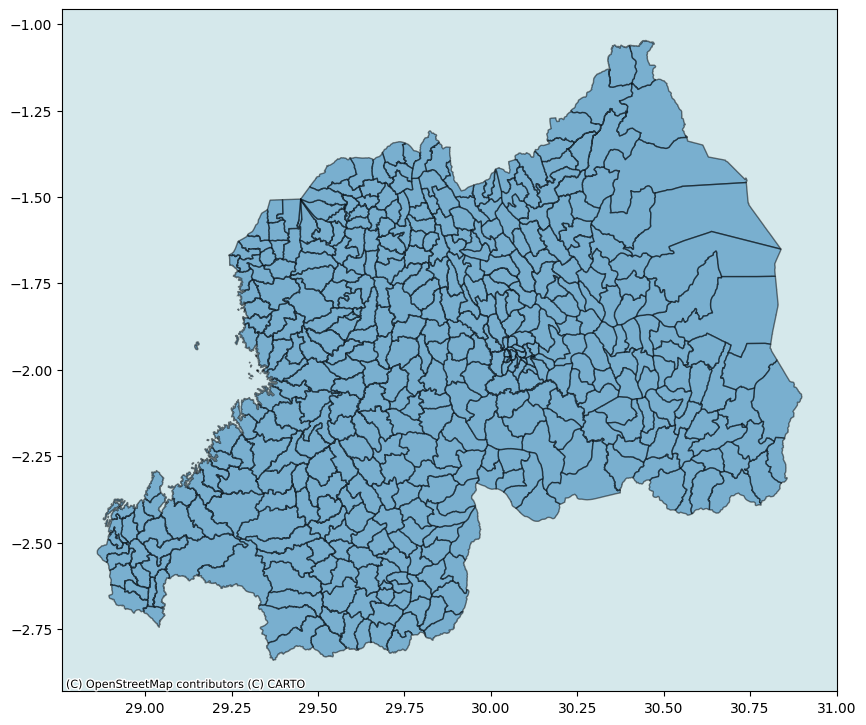

In [188]:
#change to geo-env environment
import geopandas as gpd
import contextily as ctx

# set the filepath and load in a shapefile
fp = r'data\rwa_adm3_2006_NISR_WGS1984_20181002.shp'
map_df = gpd.read_file(fp)
map_df.crs = "EPSG:3857"
basemap_df = map_df.to_crs(epsg=3857)
ax = basemap_df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, crs=basemap_df.crs.to_string(), source=ctx.providers.CartoDB.Voyager)#,zoom=10)